In [2]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import shutil
import random
from collections import defaultdict

# 1. Mount Google Drive (essential if in a new session)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define your original Pascal VOC dataset base path (source for images and annotations)
original_unzip_base_path = '/content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset'
original_annotations_dir = os.path.join(original_unzip_base_path, 'Annotations')

# Verify the original dataset path
if not os.path.exists(original_unzip_base_path):
    print(f"Error: Original dataset not found at {original_unzip_base_path}.")
    print("Please ensure the original dataset zip file is unzipped at /content/galapagos_seals_annotated_data/.")
    # Add unzipping logic if necessary for a fresh run and the zip is on Drive
    # For example:
    # zip_file_path = '/content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset.zip'
    # if os.path.exists(zip_file_path):
    #     shutil.unpack_archive(zip_file_path, '/content/galapagos_seals_annotated_data/')
    #     print("Re-unzipped original dataset.")
    # else:
    #     print("Original dataset zip file not found on Drive. Cannot proceed.")
    # exit() # Halt execution if critical

# 3. Define the ROOT directory for your NEW VGG16-specific UNDERSAMPLED dataset on Google Drive
# This will be a new folder to distinguish it from the original imbalanced one.
VGG16_DATA_ROOT_UNDERSAMPLED = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset_undersampled')

# 4. Define your class names (must match your dataset's class names in XMLs)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis", # Minority class
    "Zalophus_wollebaeki"        # Majority class
]
MINORITY_CLASS = CLASS_NAMES[0]
MAJORITY_CLASS = CLASS_NAMES[1]

# 5. Define target image size (keeping it 224x224 for ResNet-50V2 compatibility)
TARGET_IMG_SIZE = (224, 224)

print(f"\nPreparing VGG16 UNDERSAMPLED dataset for classes: {CLASS_NAMES}")
print(f"Cropped images will be resized to: {TARGET_IMG_SIZE}")
print(f"New dataset will be saved to: {VGG16_DATA_ROOT_UNDERSAMPLED}")


# --- Cleanup previous VGG16 undersampled data if it exists for a fresh start ---
if os.path.exists(VGG16_DATA_ROOT_UNDERSAMPLED):
    print(f"Cleaning up existing VGG16 undersampled data root: {VGG16_DATA_ROOT_UNDERSAMPLED}")
    shutil.rmtree(VGG16_DATA_ROOT_UNDERSAMPLED)
    print("Clean up complete.")
else:
    print(f"No existing undersampled dataset found at {VGG16_DATA_ROOT_UNDERSAMPLED}. Proceeding with creation.")


# 6. Create necessary directories for the VGG16 classification dataset
for split_folder in ['train', 'val', 'test']:
    for class_name in CLASS_NAMES:
        os.makedirs(os.path.join(VGG16_DATA_ROOT_UNDERSAMPLED, split_folder, class_name), exist_ok=True)
print("\nCreated VGG16 undersampled dataset structure on Drive.")


# Function to process and crop images, now with explicit undersampling logic
def process_and_crop_dataset_undersampled(original_base_path, original_annotations_dir, vgg16_data_root_undersampled, class_names, target_size, minority_class, majority_class):
    split_map = {
        'train': 'train',
        'validation': 'val',
        'test': 'test'
    }

    total_final_class_counts = defaultdict(int) # Overall counts for all splits

    for original_split_name, vgg16_split_name in split_map.items():
        original_split_dir = os.path.join(original_base_path, original_split_name)
        vgg16_split_output_dir = os.path.join(vgg16_data_root_undersampled, vgg16_split_name)
        print(f"\nProcessing original '{original_split_name}' split for VGG16 '{vgg16_split_name}' (Undersampling)...")

        # Step 1: Collect all potential crops for this split and count them
        all_potential_crops_in_split = defaultdict(list)
        image_paths = []
        for class_subfolder in os.listdir(original_split_dir):
            class_subfolder_path = os.path.join(original_split_dir, class_subfolder)
            if os.path.isdir(class_subfolder_path):
                for img_name in os.listdir(class_subfolder_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(class_subfolder_path, img_name))

        random.shuffle(image_paths) # Shuffle to ensure random selection of objects if multiple in image

        for image_path in image_paths:
            img_filename = os.path.basename(image_path)
            annotation_filename = os.path.splitext(img_filename)[0] + '.xml'
            annotation_filepath = os.path.join(original_annotations_dir, annotation_filename)

            if not os.path.exists(annotation_filepath):
                continue

            try:
                tree = ET.parse(annotation_filepath)
                root = tree.getroot()

                for obj in root.iter('object'):
                    label = obj.find('name').text
                    if label in class_names:
                        xml_box = obj.find('bndbox')
                        xmin = int(float(xml_box.find('xmin').text))
                        ymin = int(float(xml_box.find('ymin').text))
                        xmax = int(float(xml_box.find('xmax').text))
                        ymax = int(float(xml_box.find('ymax').text))

                        all_potential_crops_in_split[label].append({
                            'image_path': image_path,
                            'bbox': (xmin, ymin, xmax, ymax),
                            'label': label,
                            'original_filename': img_filename
                        })
            except Exception as e:
                print(f"  Error parsing annotation {annotation_filename}: {e}")

        # Step 2: Determine undersampling limit for this specific split
        minority_count_in_this_split = len(all_potential_crops_in_split[minority_class])

        # If the minority class has no samples, we can't balance it, so don't copy anything.
        if minority_count_in_this_split == 0:
            print(f"  Warning: No '{minority_class}' instances found in '{original_split_name}'. This split will be empty for both classes.")
            limit_for_this_split = 0
        else:
            limit_for_this_split = minority_count_in_this_split

        print(f"  Minority class ('{minority_class}') count in '{original_split_name}': {minority_count_in_this_split}")
        print(f"  Undersampling majority class ('{majority_class}') to limit: {limit_for_this_split}")

        # Step 3: Select crops based on the limit
        selected_crops_to_process = []
        selected_crops_to_process.extend(all_potential_crops_in_split[minority_class]) # Take all minority crops

        # Randomly select crops from the majority class up to the limit
        random.shuffle(all_potential_crops_in_split[majority_class]) # Ensure random selection
        selected_crops_to_process.extend(all_potential_crops_in_split[majority_class][:limit_for_this_split])

        random.shuffle(selected_crops_to_process) # Shuffle again to mix for saving

        processed_count_in_split = 0
        current_split_class_counts = defaultdict(int)

        # Step 4: Perform cropping and saving for the selected crops
        for crop_info in selected_crops_to_process:
            try:
                img_path = crop_info['image_path']
                bbox = crop_info['bbox']
                label = crop_info['label']
                original_filename = crop_info['original_filename']

                img = Image.open(img_path).convert('RGB')
                xmin, ymin, xmax, ymax = bbox

                img_width, img_height = img.size
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(img_width, xmax)
                ymax = min(img_height, ymax)

                if not (xmin < xmax and ymin < ymax):
                    # print(f"  Warning: Invalid effective bounding box for {original_filename} label '{label}'. Skipping crop.")
                    continue

                cropped_img = img.crop((xmin, ymin, xmax, ymax))
                cropped_img_resized = cropped_img.resize(target_size, Image.Resampling.LANCZOS)

                output_dir_for_class = os.path.join(vgg16_split_output_dir, label)
                output_filename = f"{os.path.splitext(original_filename)[0]}_{label}_{random.randint(1000, 9999)}.jpg"
                output_path = os.path.join(output_dir_for_class, output_filename)
                cropped_img_resized.save(output_path)

                current_split_class_counts[label] += 1
                total_final_class_counts[label] += 1
                processed_count_in_split += 1
            except Exception as e:
                print(f"  Error processing image {crop_info['image_path']} for VGG16 undersampling: {e}")

        print(f"  Processed {processed_count_in_split} object instances for '{original_split_name}' split.")
        print(f"  Split distribution for '{original_split_name}': {dict(current_split_class_counts)}")


    print(f"\nTotal cropped images created for UNDERSAMPLED VGG16 dataset: {sum(total_final_class_counts.values())}")
    print("Class distribution (UNDERSAMPLED - total):")
    for cls, count in total_final_class_counts.items():
        print(f"  {cls}: {count} images")


# Run the data preparation process for undersampling
process_and_crop_dataset_undersampled(
    original_unzip_base_path,
    original_annotations_dir,
    VGG16_DATA_ROOT_UNDERSAMPLED,
    CLASS_NAMES,
    TARGET_IMG_SIZE,
    MINORITY_CLASS,
    MAJORITY_CLASS
)

# --- Final Verification of the created dataset ---
print("\nVerifying UNDERSAMPLED VGG16 dataset structure on Drive:")
for split_folder in ['train', 'val', 'test']:
    print(f"\n--- {split_folder} Split ---")
    for class_name in CLASS_NAMES:
        path = os.path.join(VGG16_DATA_ROOT_UNDERSAMPLED, split_folder, class_name)
        if os.path.exists(path):
            num_files = len(os.listdir(path))
            print(f"  {class_name}: {num_files} images")
        else:
            print(f"  {class_name}: Path does not exist.")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!

Preparing VGG16 UNDERSAMPLED dataset for classes: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Cropped images will be resized to: (224, 224)
New dataset will be saved to: /content/drive/My Drive/vgg16_seals_classification_dataset_undersampled
Cleaning up existing VGG16 undersampled data root: /content/drive/My Drive/vgg16_seals_classification_dataset_undersampled
Clean up complete.

Created VGG16 undersampled dataset structure on Drive.

Processing original 'train' split for VGG16 'train' (Undersampling)...
  Minority class ('Arctocephalus_galapagoensis') count in 'train': 38
  Undersampling majority class ('Zalophus_wollebaeki') to limit: 38
  Processed 76 object instances for 'train' split.
  Split distribution for 'train': {'Zalophus_wollebaeki': 38, 'Arctocephalus_galapagoensis': 38}



Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!

Training ResNet-50V2 model on UNDERSAMPLED data for 2 classes: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Using dataset from: /content/drive/My Drive/vgg16_seals_classification_dataset_undersampled
Cropped images resized to: (224, 224)
Found 76 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 10 images belonging to 2 classes.

Data generators created.
Found 76 training images belonging to 2 classes.
Found 8 validation images belonging to 2 classes.
Found 10 test images belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 49,255,682 (187.90 MB)

 Trainable params: 25,690,882 (98.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)


Starting ResNet-50V2 model training (Undersampled Case)...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7089 - loss: 1.4807
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_undersampled_case/best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7090 - loss: 1.5103 - val_accuracy: 0.7500 - val_loss: 1.4579 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9258 - loss: 0.3752
Epoch 2: val_accuracy did not improve from 0.75000
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9275 - loss: 0.3705 - val_accuracy: 0.7500 - val_loss: 1.2621 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9749 - loss: 0.0829
Epoch 3: val_accuracy did not improve from 0.75000
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9748 - loss: 0.0867 - val_accuracy: 0.6250 - val_loss: 8.5125 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9464 - loss: 0.5607
Epoch 4: val_accuracy did not improve from 0.75000
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9477 - loss: 0.5426 - val_accuracy: 0.6250 - val_loss: 2.9286 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━

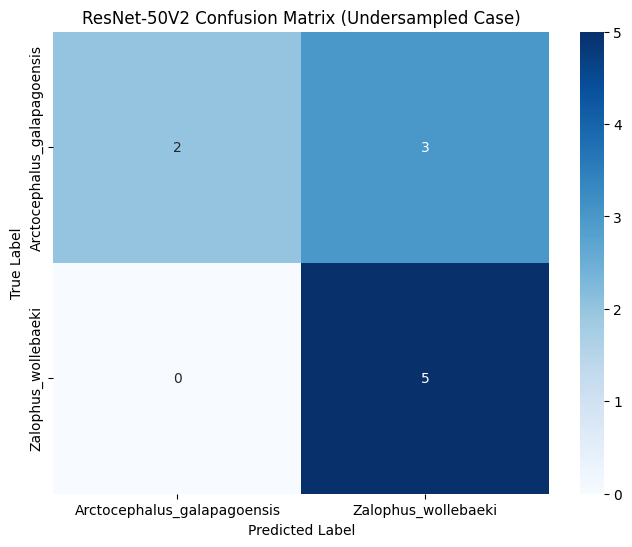

Confusion matrix plot saved to: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_undersampled_case/confusion_matrix.png

Loading training history from: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_undersampled_case/training_history.json


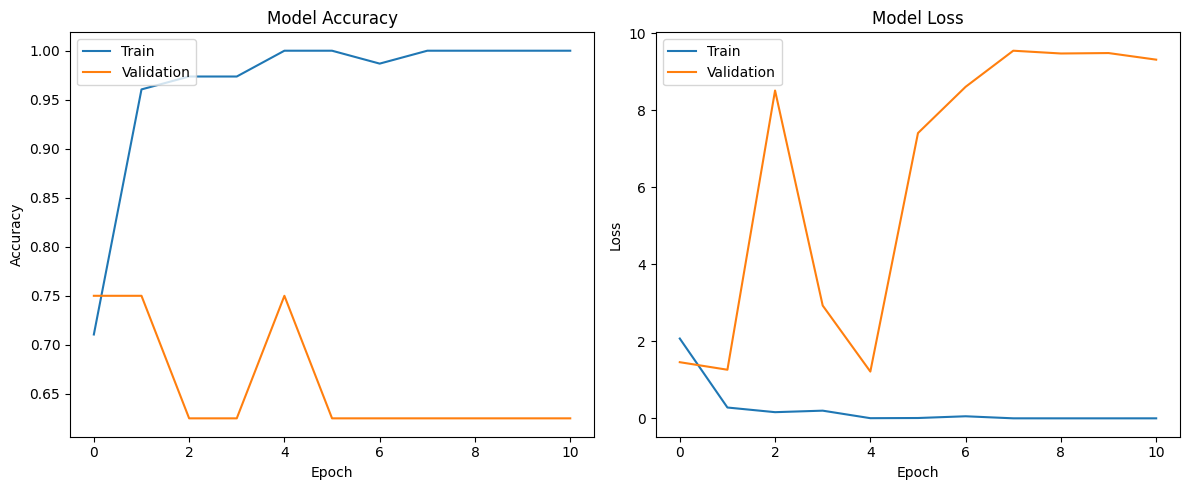

Training history plots saved to: /content/drive/My Drive/vgg16_training_results/resnet50v2_classification_undersampled_case/training_history_plots.png
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - accuracy: 0.5833 - loss: 4.4135

Overall Test Loss: 4.6073
Overall Test Accuracy: 0.6250


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Mount Google Drive (essential if in a new session)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define the ROOT directory for your UNDERSAMPLED dataset on Google Drive
# This is the NEW path pointing to the balanced data.
UNDERSAMPLED_DATA_ROOT = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset_undersampled')

# Verify that the dataset exists
if not os.path.exists(UNDERSAMPLED_DATA_ROOT):
    print(f"Error: Undersampled dataset not found at {UNDERSAMPLED_DATA_ROOT}.")
    print("Please ensure the 'Step 1: Prepare the Undersampled Dataset' cell was run successfully.")
    exit()

# 3. Define dataset paths for training, validation, and test splits
TRAIN_DIR_UNDERSAMPLED = os.path.join(UNDERSAMPLED_DATA_ROOT, 'train')
VAL_DIR_UNDERSAMPLED = os.path.join(UNDERSAMPLED_DATA_ROOT, 'val')
TEST_DIR_UNDERSAMPLED = os.path.join(UNDERSAMPLED_DATA_ROOT, 'test')

# 4. Define your class names (must match the folder names in your dataset)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]
NUM_CLASSES = len(CLASS_NAMES)
TARGET_IMG_SIZE = (224, 224) # ResNet50V2's common input size
BATCH_SIZE = 4 # Reduced batch size because dataset is much smaller

print(f"\nTraining ResNet-50V2 model on UNDERSAMPLED data for {NUM_CLASSES} classes: {CLASS_NAMES}")
print(f"Using dataset from: {UNDERSAMPLED_DATA_ROOT}")
print(f"Cropped images resized to: {TARGET_IMG_SIZE}")


# 5. Data Generators for training, validation, and testing
# Use preprocess_input specific to ResNet50V2
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_UNDERSAMPLED,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR_UNDERSAMPLED,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR_UNDERSAMPLED,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

print("\nData generators created.")
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {val_generator.samples} validation images belonging to {val_generator.num_classes} classes.")
print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")


# 6. Build the ResNet-50V2 Model for Transfer Learning
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(TARGET_IMG_SIZE[0], TARGET_IMG_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 7. Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 8. Define Callbacks for training
# ModelCheckpoint to save the best model weights based on validation accuracy
model_checkpoint_path_undersampled = os.path.join( # New path for this experiment
    '/content/drive/My Drive',
    'vgg16_training_results',
    'resnet50v2_classification_undersampled_case', # Specific subfolder for undersampling
    'best_model.h5'
)
os.makedirs(os.path.dirname(model_checkpoint_path_undersampled), exist_ok=True)

checkpoint = ModelCheckpoint(
    model_checkpoint_path_undersampled,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=0.000001,
    mode='max',
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# 9. Train the Model
EPOCHS_UNDERSAMPLED = 50 # Start with 50 epochs

print("\nStarting ResNet-50V2 model training (Undersampled Case)...")
history_undersampled = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_UNDERSAMPLED,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

print("\nResNet-50V2 Training (Undersampled Case) complete!")
print(f"Best model saved to: {model_checkpoint_path_undersampled}")

# Save training history
history_undersampled_dict = history_undersampled.history
history_filepath_undersampled = os.path.join(os.path.dirname(model_checkpoint_path_undersampled), 'training_history.json')
with open(history_filepath_undersampled, 'w') as f:
    json.dump(history_undersampled_dict, f)
print(f"Training history saved to: {history_filepath_undersampled}")


# --- 10. Evaluate on test set and get more metrics ---
print("\nEvaluating model on the test set for detailed metrics...")

Y_pred_proba_undersampled = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0))
Y_pred_classes_undersampled = np.argmax(Y_pred_proba_undersampled, axis=1)

Y_true_undersampled = test_generator.classes[test_generator.index_array]

print("\n--- ResNet-50V2 Classification Report (Undersampled Case) ---")
report_undersampled = classification_report(Y_true_undersampled, Y_pred_classes_undersampled, target_names=CLASS_NAMES)
print(report_undersampled)

# Save Classification Report to Drive
report_filepath_undersampled = os.path.join(os.path.dirname(model_checkpoint_path_undersampled), 'classification_report.txt')
with open(report_filepath_undersampled, 'w') as f:
    f.write(report_undersampled)
print(f"Classification report saved to: {report_filepath_undersampled}")

print("\n--- ResNet-50V2 Confusion Matrix (Undersampled Case) ---")
cm_undersampled = confusion_matrix(Y_true_undersampled, Y_pred_classes_undersampled)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_undersampled, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet-50V2 Confusion Matrix (Undersampled Case)')
plt.show()

# Save Confusion Matrix plot to Drive
cm_filepath_undersampled = os.path.join(os.path.dirname(model_checkpoint_path_undersampled), 'confusion_matrix.png')
plt.savefig(cm_filepath_undersampled)
print(f"Confusion matrix plot saved to: {cm_filepath_undersampled}")
plt.close() # Close plot to prevent it from showing multiple times if run in loop


# Optional: Load and Plot Training History
history_plot_filepath_undersampled = os.path.join(os.path.dirname(model_checkpoint_path_undersampled), 'training_history_plots.png')
if os.path.exists(history_filepath_undersampled):
    print(f"\nLoading training history from: {history_filepath_undersampled}")
    with open(history_filepath_undersampled, 'r') as f:
        history_data_undersampled = json.load(f)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_data_undersampled['accuracy'])
    plt.plot(history_data_undersampled['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history_data_undersampled['loss'])
    plt.plot(history_data_undersampled['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.savefig(history_plot_filepath_undersampled)
    print(f"Training history plots saved to: {history_plot_filepath_undersampled}")
    plt.close()
else:
    print(f"\nTraining history file not found at: {history_filepath_undersampled}")


overall_test_loss_undersampled, overall_test_accuracy_undersampled = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"\nOverall Test Loss: {overall_test_loss_undersampled:.4f}")
print(f"Overall Test Accuracy: {overall_test_accuracy_undersampled:.4f}")